In [10]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import csv
import numpy as np
import cv2
import time
from sklearn import tree
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

In [11]:
# function for loading images
def load_images_labels(img_folder, label_file):
    with open(label_file) as f:
        reader = csv.reader(f)
        next(reader) # skip header
        labels = []
        images = []
        for row in reader:
            img_filename = row[0]
            img = mpimg.imread(os.path.join(img_folder,img_filename))
            if img is not None:
                images.append(img)
                labels.append(int(row[1]))
        return np.array(images), np.array(labels)

training_imgs, training_labels = load_images_labels('train/', 'train.csv')

In [12]:
# normalize images
def normalize_images(training_imgs):
    Mean_RGB = np.array([128.41563722, 115.24518493, 119.38645491])
    Std_RGB = np.array([38.55379149, 35.64913446, 39.07419321])
    n_training_imgs = (training_imgs - Mean_RGB)/Std_RGB
    return n_training_imgs

n_training_imgs = normalize_images(training_imgs)
n_training_imgs = np.reshape(n_training_imgs, (training_imgs.shape[0], 32*32*3))

In [15]:
# calculate priors 
prior_class_0 = len(training_labels[training_labels[:]==0])/len(training_labels)
prior_class_1 = len(training_labels[training_labels[:]==1])/len(training_labels)

print(prior_class_0)
print(prior_class_1)

0.24937142857142858
0.7506285714285714


In [8]:
#transform data using PCA
def PCA(X, error):
    
    print(error)
    
    # calculate covariance matrix of transpose of X
    X_cov = np.cov(X.T)
    eig_vals, eig_vects = np.linalg.eig(X_cov)
    
    # rank eigenvectors and values from highest to lowest
    idx = eig_vals.argsort()[::-1]   
    eig_vals = eig_vals[idx]
    eig_vects = eig_vects[:,idx]
    
    # sum eigenvalues
    sigma_lamda = np.sum(eig_vals)
    
    basis_i = 0  
    
    # select axes with error rate < error
    for i in range(len(eig_vals)-1, -1, -1):
        
        vals_sum = np.sum(eig_vals[i:])
        
        if (vals_sum/sigma_lamda >= error):
            basis_i = i
            break
    
    # multiply dataset by optimal basis 
    P = np.dot(eig_vects[:, :basis_i+1].T , X.T)  
    
    return P.T

# reduce normalized datasets using error rate < 0.10
p_training_imgs_0_45 = PCA(n_training_imgs, 0.45)
p_training_imgs_0_5 = PCA(n_training_imgs, 0.5)
p_training_imgs_0_55 = PCA(n_training_imgs, 0.55)
p_training_imgs_0_6 = PCA(n_training_imgs, 0.6)

0.45
0.5
0.55
0.6
[[-29.94074365   1.72754794   5.11200181   2.25943268   1.24881991]
 [ -5.08118002  13.38036557   6.68362505  -6.91213878   6.39593127]
 [-28.68901359   4.87196245  -8.20554382  -5.59953733   4.89753078]
 ...
 [ -2.17015128   7.53213772  -7.39882982   0.91154427  -5.2785461 ]
 [-20.97945248  -2.17865192   1.33181133   0.55790314  -0.33851133]
 [ -7.80848722 -12.22778193  -6.26199341   1.08672958  -3.25325517]]
(17500, 5)


In [9]:
p_training_imgs_0_01 = PCA(n_training_imgs, 0.01)
p_training_imgs_0_05 = PCA(n_training_imgs, 0.05)
p_training_imgs_0_1 = PCA(n_training_imgs, 0.1)
p_training_imgs_0_15 = PCA(n_training_imgs, 0.15)
p_training_imgs_0_2 = PCA(n_training_imgs, 0.2)
p_training_imgs_0_25 = PCA(n_training_imgs, 0.25)
p_training_imgs_0_3 = PCA(n_training_imgs, 0.3)
p_training_imgs_0_35 = PCA(n_training_imgs, 0.35)
p_training_imgs_0_4 = PCA(n_training_imgs, 0.4)

0.01
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4


In [10]:
# function for calculating sample mean
def mle_mean(data):
    n = len(data)
    mean = np.sum(data, axis=0)/n
    return mean
def FLD(X, y):
    X_0 = X[y[:] == 0.0]
    X_1 = X[y[:] == 1.0]
    
    m_0 = mle_mean(X_0)
    m_1 = mle_mean(X_1)
    
    X = X.T
    X_0 = X_0.T
    X_1 = X_1.T
    
    m_0 = m_0.reshape(len(m_0), 1)
    m_1 = m_1.reshape(len(m_1), 1)
    
    S_0 = np.dot((X_0 - m_0), (X_0 - m_0).T)
    S_1 = np.dot((X_1 - m_1), (X_1 - m_1).T)
    
    S_w = S_0 + S_1
    
    w = np.dot(np.linalg.inv(S_w), m_0 - m_1)

    fX = np.dot(w.T, X)

    return fX.reshape(fX.shape[1], 1)
    
f_training_images = FLD(n_training_imgs, training_labels)

In [11]:
# function for printing confusion matrix and performance metrics
def get_metrics(y_pred, y_truth, print_metrics = False, save=False, name='matrix.csv'):
    tn = 0
    tp = 0 
    fn = 0 
    fp = 0
    
    for i in range(len(y_pred)):
        #calc TP
        if y_pred[i] == 1 and y_truth[i] == 1:
            tp += 1
    
        #calc TN 
        if y_pred[i] == 0 and y_truth[i] == 0:
            tn += 1
    
        #calc FP
        if y_pred[i] == 1 and y_truth[i] == 0:
            fp += 1
    
        #calc FN
        if y_pred[i] == 0 and y_truth[i] == 1:
            fn += 1
    
    if (print_metrics):
        # print confusion matrix
        print('\t\tPredicted Class')
        print('True Class\t', 'No', '\tYes')
        print('No\t\t', tn, '\t', fp)
        print('Yes\t\t', fn, '\t', tp )
        print()
    
    if (tn + tp + fn + fp) == 0.0:
        accuracy = 0.0
    else:
        accuracy = (tn + tp) / (tn + tp + fn + fp)
    
    if (tp + fn) == 0.0:
        sensitivity = 0.0
    else:
        sensitivity = tp / (tp + fn)  
    
    if (tp + fp) == 0.0:
        precision = 0.0
    else:
        precision = tp / (tp + fp)
    
    if (tn + fp) == 0.0:
        specificity = 0.0
    else:
        specificity = tn / (tn + fp)
    
    if print_metrics:
        print('Accuracy', accuracy)
        print('Sensitivity', sensitivity)
        print('Precision', precision)
        print('Specificity', specificity)
        
    if save:
        mat = np.asarray([ [tn, fp], [fn, tp] ])
        np.savetxt(name + '.csv', mat, delimiter=",", fmt='%i')
        np.savetxt(name+'_pred.csv', y_pred, delimiter=",", fmt='%i')
    
    return accuracy, sensitivity, precision, specificity, tp, tn, fp, fn

In [12]:
# function for finding MLE mean
def mle_mean(data):
    n = len(data)
    mean = np.sum(data, axis=0)/n
    return mean

# function for calculating covariance using MLE given mu
def mle_covariance(data, mu):
    
    n = len(data)
    diff = data - mu
    diff = diff.T
    product = np.matmul(diff, diff.T)
    covariance = product/n
    
    return covariance

# main maximum a-posteriori probability method
# returns test accuracy given test dataset and parameters
def mpp(X_train, y_train, X_test, prior_class_0, prior_class_1, case):
    
    # get dimension of data
    if X_train.ndim == 1:
        d = 1
        X_train = X_train.reshape(len(X_train), 1)
    else:
        d = X_train.shape[1]
    
    # split training data into classes
    X_train_class_0 = X_train[y_train[:] == 0.0]
    X_train_class_1 = X_train[y_train[:] == 1.0]
    
    # predict class for each value in test dataset
    y_pred = []
    
    # get MLE mean for individual classes
    mean = mle_mean(X_train).reshape(d,1)
    mean_class_0 = mle_mean(X_train_class_0).reshape(d,1)
    mean_class_1 = mle_mean(X_train_class_1).reshape(d,1)
    
    cov_mat0 = mle_covariance(X_train_class_0, mean_class_0.T)
    cov_mat1 = mle_covariance(X_train_class_1, mean_class_1.T)
    print('det 0', np.linalg.det(cov_mat0))
    
    print('det 1', np.linalg.det(cov_mat1))
    
    count = 0 
    for x in X_test:
        if count % 1000 == 0:
            print(count)
        count += 1
        
        x = x.reshape(d,1)
        
        # Case 1: Assume Gaussian PDF, covariance matrices are same, & independent features
        # Also known Euclidean Norm or Minimum Distance Classifier
        if case == 1:
            # get MLE mean for individual classes
            mean = mle_mean(X_train).reshape(d,1)
            mean_class_0 = mle_mean(X_train_class_0).reshape(d,1)
            mean_class_1 = mle_mean(X_train_class_1).reshape(d,1)
            
            # calculate single covariance matrix
            #print('calc cov')
            cov_mat = mle_covariance(X_train, mean.T)#np.cov(X_train[:,0], X_train[:,1])
            
            # calculate discriminant function for class 0
            v = x - mean_class_0
            g0 = -0.5*np.matmul(v.T, v)/cov_mat[0,0] + np.log(prior_class_0)

            # calculate discriminant function for class 1
            v = x - mean_class_1
            g1 = -0.5*np.matmul(v.T, v)/cov_mat[0,0] + np.log(prior_class_1)
            
        # Case 2: Assume Gaussian PDF & covariance matrices are same
        # Also known Squared Mahalanobis Distance Classifier
        elif case == 2:
            # get MLE mean for individual classes
            mean = mle_mean(X_train).reshape(d,1)
            mean_class_0 = mle_mean(X_train_class_0).reshape(d,1)
            mean_class_1 = mle_mean(X_train_class_1).reshape(d,1)
            
            # calculate single covariance matrix
            cov_mat = mle_covariance(X_train, mean.T)*10.0#cov_mat = np.cov(X_train[:,0], X_train[:,1])
            invC = np.linalg.inv(cov_mat)
            
            # calculate discriminant function for class 0
            v = x - mean_class_0
            g0 = -0.5*np.matmul(np.matmul(v.T, invC), v) + np.log(prior_class_0)

            # calculate discriminant function for class 1
            v = x - mean_class_1
            g1 = -0.5*np.matmul(np.matmul(v.T, invC), v) + np.log(prior_class_1)

        # Case 3: Assume Gaussian PDF only
        # Equivalent of MPP method
        else:
            
            # get MLE mean for individual classes
            mean = mle_mean(X_train).reshape(d,1)
            mean_class_0 = mle_mean(X_train_class_0).reshape(d,1)
            mean_class_1 = mle_mean(X_train_class_1).reshape(d,1)
            
            # calculate covariance matrices for both classes
            #print(X_train_class_0, mean_class_0.T)
            cov_mat0 = mle_covariance(X_train_class_0, mean_class_0.T)
            cov_mat1 = mle_covariance(X_train_class_1, mean_class_1.T)
            
            # calculate discriminant function for class 0
            v = x - mean_class_0
            invC = np.linalg.inv(cov_mat0)
            g0 = -0.5*np.matmul(np.matmul(v.T, invC), v) - 0.5*np.log(np.linalg.det(cov_mat0)) + np.log(prior_class_0)
        
            # calculate discriminant function for class 1
            v = x - mean_class_1
            invC = np.linalg.inv(cov_mat1)
            g1 = -0.5*np.matmul(np.matmul(v.T, invC), v) - 0.5*np.log(np.linalg.det(cov_mat1)) + np.log(prior_class_1)
        
        # append classification 
        if g0 > g1:
            y_pred.append(0.0)
        else:
            y_pred.append(1.0)
            
    return y_pred

In [13]:
# function for training MPP classifier with 5-fold cross validation
def train_mpp_with_validation(X_train, y_train, case, folds=5):  
    
    accuracies = []
    models = []
    
    # k fold cross validation
    for f in range(0, folds):
        

        print('fold', f)

        n = len(X_train)
        split_ind_start = int (f * n / folds) 
        split_ind_stop  = int ((f+1) * n / folds)
            

        if f == 0:
            X_train_tmp = X_train[int(split_ind_stop):]
            y_train_tmp = y_train[int(split_ind_stop):]

        elif f == folds-1:
            X_train_tmp = X_train[:int(split_ind_start)]
            y_train_tmp = y_train[:int(split_ind_start)]

        else:
            if X_train.ndim != 1:
                X_train_tmp = np.concatenate([X_train[:int(split_ind_start)], X_train[int(split_ind_stop):]], axis = 0)
                y_train_tmp = np.concatenate([y_train[:int(split_ind_start)], y_train[int(split_ind_stop):]], axis = 0)
            else:
                X_train_tmp = np.concatenate((X_train[:int(split_ind_start)], X_train[int(split_ind_stop):]))
                y_train_tmp = np.concatenate((y_train[:int(split_ind_start)], y_train[int(split_ind_stop):]))


        # calculate priors 
        prior_class_0 = len(y_train_tmp[y_train_tmp[:]==0])/len(y_train_tmp)
        prior_class_1 = len(y_train_tmp[y_train_tmp[:]==1])/len(y_train_tmp)
        
                
        X_valid = X_train[int(split_ind_start):int(split_ind_stop)]
        y_valid = y_train[int(split_ind_start):int(split_ind_stop)]
        
        # MPP Case 1
        if case == 1:
            y_pred_valid = mpp(X_train, y_train, X_valid, prior_class_0, prior_class_1, case)
        
        # MPP Case 2
        elif case == 2:
            y_pred_valid = mpp(X_train, y_train, X_valid, prior_class_0, prior_class_1, case)
        
        # MPP Case 3
        else:
            y_pred_valid = mpp(X_train, y_train, X_valid, prior_class_0, prior_class_1, case)
            
        performance_metrics = get_metrics(y_pred_valid, y_valid, print_metrics = True)
        
        print('predicted labels', y_pred_valid)
        print('true labels', y_valid)
        
        
        print(performance_metrics)
        accuracy = performance_metrics[0]
        print('Fold', f + 1, 'accuracy:', accuracy)
        accuracies.append(accuracy)
        models.append(performance_metrics)
    
    print('Mean validation accuracy:', np.mean(accuracies))
    
    mean_performance_metrics = np.mean(np.array(models), axis = 0)
    
    return mean_performance_metrics

In [14]:
# function for calculating Euclidean distance
def euc_dist(x, y):
    
    diff = x-y
    
    if(diff.ndim == 1):
        return np.abs(diff)
    
    return np.linalg.norm(diff, axis = 1)

# k-nearest neighbors implementation
def knn(X, y, X_te, prior_class_0, prior_class_1, k):
    
    start_time = time.time()
    
    predictions = np.zeros(len(X_te))
    
    indices = np.array([ind for ind in range(len(X))])
    
    prior_class_0_actual = len(X[y[:] == 0.0])/len(X)
    prior_class_1_actual = len(X[y[:] == 1.0])/len(X)
    
    for i in range(len(X_te)):
        s = euc_dist(X_te[i], X)
        s = np.column_stack((indices, s))
        s = s[s[:,1].argsort()]
        
        # get k nearest neighbors
        knns = s[:k]
        classes = []
        
        for ind in knns[:,0]:
            classes.append(int(y[int(ind)]))
    
        k_0 = classes.count(0)
        
        n = len(X)
        
        r_0 = prior_class_0 * prior_class_0_actual
        
        g_0 = k_0 / k * r_0
        
        k_1 = classes.count(1)
    
        g_1 = k_1 / k * (1.0 - prior_class_0_actual * r_0)
    
        predictions[i] = g_0 < g_1
    
    end_time = time.time()
    
    print("Elapsed Time:", end_time - start_time)
    
    return predictions

def train_knn_with_validation(X_train, y_train, k, folds=5):  
    
    accuracies = []
    models = []
    
    # k fold cross validation
    for f in range(0, folds):

        n = len(X_train)
        split_ind_start = int (f * n / folds) 
        split_ind_stop  = int ((f+1) * n / folds)
            

        if f == 0:
            X_train_tmp = X_train[int(split_ind_stop):]
            y_train_tmp = y_train[int(split_ind_stop):]

        elif f == folds-1:
            X_train_tmp = X_train[:int(split_ind_start)]
            y_train_tmp = y_train[:int(split_ind_start)]

        else:
            if X_train.ndim != 1:
                X_train_tmp = np.concatenate([X_train[:int(split_ind_start)], X_train[int(split_ind_stop):]], axis = 0)
                y_train_tmp = np.concatenate([y_train[:int(split_ind_start)], y_train[int(split_ind_stop):]], axis = 0)
            else:
                X_train_tmp = np.concatenate((X_train[:int(split_ind_start)], X_train[int(split_ind_stop):]))
                y_train_tmp = np.concatenate((y_train[:int(split_ind_start)], y_train[int(split_ind_stop):]))

        # calculate priors 
        prior_class_0 = len(y_train_tmp[y_train_tmp[:]==0])/len(y_train_tmp)
        prior_class_1 = len(y_train_tmp[y_train_tmp[:]==1])/len(y_train_tmp)
        
                
        X_valid = X_train[int(split_ind_start):int(split_ind_stop)]
        y_valid = y_train[int(split_ind_start):int(split_ind_stop)]
        
        # KNN
        y_pred_valid = knn(X_train_tmp, y_train_tmp, X_valid, prior_class_0, prior_class_1, k)
        
        performance_metrics = get_metrics(y_pred_valid, y_valid)
        accuracy = performance_metrics[0]
        print('Fold', f + 1, 'accuracy:', accuracy)
        accuracies.append(accuracy)
        models.append(performance_metrics)
    
    print('Mean validation accuracy:', np.mean(accuracies))
    
    mean_performance_metrics = np.mean(np.array(models), axis = 0)
    
    return mean_performance_metrics

In [15]:
# mpp case 1
train_mpp_with_validation(p_training_imgs, training_labels, 1, folds=5)
train_mpp_with_validation(f_training_images, training_labels, 1, folds=5)

NameError: name 'p_training_imgs' is not defined

In [118]:
# mpp case 2
train_mpp_with_validation(p_training_imgs, training_labels, 2, folds=5)
train_mpp_with_validation(f_training_images, training_labels, 2, folds=5)

fold 0
0
1000
2000
3000
Fold 1 accuracy: 0.7474285714285714
fold 1
0
1000
2000
3000
Fold 2 accuracy: 0.7417142857142857
fold 2
0
1000
2000
3000
Fold 3 accuracy: 0.7525714285714286
fold 3
0
1000
2000
3000
Fold 4 accuracy: 0.7622857142857142
fold 4
0
1000
2000
3000
Fold 5 accuracy: 0.7491428571428571
Mean validation accuracy: 0.7506285714285713
fold 0
0
1000
2000
3000
Fold 1 accuracy: 0.7474285714285714
fold 1
0
1000
2000
3000
Fold 2 accuracy: 0.7417142857142857
fold 2
0
1000
2000
3000
Fold 3 accuracy: 0.7525714285714286
fold 3
0
1000
2000
3000
Fold 4 accuracy: 0.7622857142857142
fold 4
0
1000
2000
3000
Fold 5 accuracy: 0.7491428571428571
Mean validation accuracy: 0.7506285714285713


array([7.50628571e-01, 7.50628571e-01, 1.00000000e+00, 0.00000000e+00,
       2.62720000e+03, 0.00000000e+00, 0.00000000e+00, 8.72800000e+02])

In [170]:
# mpp case 3
train_mpp_with_validation(p_training_imgs, training_labels, 3, folds=5)
train_mpp_with_validation(f_training_images, training_labels, 3, folds=5)

fold 0
det 0 0.0012435682827854468
det 1 0.004407162183016091
0
1000
2000
3000
		Predicted Class
True Class	 No 	Yes
No		 391 	 493
Yes		 232 	 2384

Accuracy 0.7928571428571428
Sensitivity 0.9113149847094801
Precision 0.8286409454292666
Specificity 0.4423076923076923
predicted labels [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0

1000
2000
3000
		Predicted Class
True Class	 No 	Yes
No		 397 	 507
Yes		 233 	 2363

Accuracy 0.7885714285714286
Sensitivity 0.9102465331278891
Precision 0.8233449477351916
Specificity 0.4391592920353982
predicted labels [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

1000
2000
3000
		Predicted Class
True Class	 No 	Yes
No		 414 	 452
Yes		 263 	 2371

Accuracy 0.7957142857142857
Sensitivity 0.9001518602885346
Precision 0.8398866454126815
Specificity 0.4780600461893764
predicted labels [1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.

1000
2000
3000
		Predicted Class
True Class	 No 	Yes
No		 380 	 452
Yes		 248 	 2420

Accuracy 0.8
Sensitivity 0.9070464767616192
Precision 0.8426183844011143
Specificity 0.4567307692307692
predicted labels [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

1000
2000
3000
		Predicted Class
True Class	 No 	Yes
No		 391 	 487
Yes		 234 	 2388

Accuracy 0.794
Sensitivity 0.9107551487414187
Precision 0.8306086956521739
Specificity 0.44533029612756264
predicted labels [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0,

1000
2000
3000
		Predicted Class
True Class	 No 	Yes
No		 466 	 418
Yes		 218 	 2398

Accuracy 0.8182857142857143
Sensitivity 0.9166666666666666
Precision 0.8515625
Specificity 0.5271493212669683
predicted labels [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

1000
2000
3000
		Predicted Class
True Class	 No 	Yes
No		 453 	 451
Yes		 210 	 2386

Accuracy 0.8111428571428572
Sensitivity 0.9191063174114021
Precision 0.8410292562566091
Specificity 0.5011061946902655
predicted labels [1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

1000
2000
3000
		Predicted Class
True Class	 No 	Yes
No		 480 	 386
Yes		 243 	 2391

Accuracy 0.8202857142857143
Sensitivity 0.907744874715262
Precision 0.8610010803024847
Specificity 0.5542725173210161
predicted labels [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

1000
2000
3000
		Predicted Class
True Class	 No 	Yes
No		 451 	 381
Yes		 239 	 2429

Accuracy 0.8228571428571428
Sensitivity 0.9104197901049476
Precision 0.8644128113879004
Specificity 0.5420673076923077
predicted labels [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.

1000
2000
3000
		Predicted Class
True Class	 No 	Yes
No		 467 	 411
Yes		 238 	 2384

Accuracy 0.8145714285714286
Sensitivity 0.9092295957284515
Precision 0.8529516994633274
Specificity 0.5318906605922551
predicted labels [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.

array([8.17428571e-01, 9.12633449e-01, 8.54191469e-01, 5.31297200e-01,
       2.39760000e+03, 4.63400000e+02, 4.09400000e+02, 2.29600000e+02])

In [30]:
# train and test knn classifier for different k values: nX
p_validation_accuracies = []
f_validation_accuracies = []
    
# plot KNN accuracies

def plot_accuracies(k, accuracies, methods, title, xlabel, ylabel):
    
    for i in range(len(accuracies)):
        plt.plot(k, accuracies[i], label=methods[i])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# knn
train_knn_with_validation(n_training_imgs, training_labels, 2, folds=5)

Elapsed Time: 994.4365885257721
Fold 1 accuracy: 0.4065714285714286
Elapsed Time: 976.5179052352905
Fold 2 accuracy: 0.4177142857142857
Elapsed Time: 1008.782782793045
Fold 3 accuracy: 0.4097142857142857
Elapsed Time: 995.7538435459137
Fold 4 accuracy: 0.3954285714285714
Elapsed Time: 1023.48228931427
Fold 5 accuracy: 0.4117142857142857
Mean validation accuracy: 0.4082285714285714


array([4.08228571e-01, 2.17134540e-01, 9.75429623e-01, 9.83525296e-01,
       5.70400000e+02, 8.58400000e+02, 1.44000000e+01, 2.05680000e+03])

In [31]:
train_knn_with_validation(p_training_imgs_0_01, training_labels, 2, folds=5)

Elapsed Time: 314.257705450058
Fold 1 accuracy: 0.41942857142857143
Elapsed Time: 303.83858466148376
Fold 2 accuracy: 0.4322857142857143
Elapsed Time: 306.75239419937134
Fold 3 accuracy: 0.4268571428571429
Elapsed Time: 305.0508325099945
Fold 4 accuracy: 0.4094285714285714
Elapsed Time: 315.1039547920227
Fold 5 accuracy: 0.42628571428571427
Mean validation accuracy: 0.4228571428571429


array([4.22857143e-01, 2.37081390e-01, 9.75587819e-01, 9.82162155e-01,
       6.22800000e+02, 8.57200000e+02, 1.56000000e+01, 2.00440000e+03])

In [32]:
train_knn_with_validation(f_training_images, training_labels, 2, folds=5)

Elapsed Time: 3.941739559173584
Fold 1 accuracy: 0.9022857142857142
Elapsed Time: 3.9367849826812744
Fold 2 accuracy: 0.9034285714285715
Elapsed Time: 3.9080615043640137
Fold 3 accuracy: 0.9065714285714286
Elapsed Time: 3.920804500579834
Fold 4 accuracy: 0.908
Elapsed Time: 3.9356789588928223
Fold 5 accuracy: 0.9082857142857143
Mean validation accuracy: 0.9057142857142857


array([9.05714286e-01, 9.67659047e-01, 9.12093681e-01, 7.19414569e-01,
       2.54220000e+03, 6.27800000e+02, 2.45000000e+02, 8.50000000e+01])

In [33]:
train_knn_with_validation(p_training_imgs_0_05, training_labels, 2, folds=5)

Elapsed Time: 215.80984950065613
Fold 1 accuracy: 0.5034285714285714
Elapsed Time: 210.69499945640564
Fold 2 accuracy: 0.5111428571428571
Elapsed Time: 215.2423141002655
Fold 3 accuracy: 0.5082857142857143
Elapsed Time: 213.75620555877686
Fold 4 accuracy: 0.4888571428571429
Elapsed Time: 215.61221504211426
Fold 5 accuracy: 0.5048571428571429
Mean validation accuracy: 0.5033142857142858


array([5.03314286e-01, 3.46715162e-01, 9.76428441e-01, 9.74832187e-01,
       9.10800000e+02, 8.50800000e+02, 2.20000000e+01, 1.71640000e+03])

In [34]:
train_knn_with_validation(p_training_imgs_0_1, training_labels, 2, folds=5)

Elapsed Time: 143.65322470664978
Fold 1 accuracy: 0.6268571428571429
Elapsed Time: 141.29202437400818
Fold 2 accuracy: 0.6348571428571429
Elapsed Time: 140.54848837852478
Fold 3 accuracy: 0.6222857142857143
Elapsed Time: 140.42078924179077
Fold 4 accuracy: 0.5982857142857143
Elapsed Time: 143.2639775276184
Fold 5 accuracy: 0.6205714285714286
Mean validation accuracy: 0.6205714285714286


array([6.20571429e-01, 5.10984705e-01, 9.68955325e-01, 9.50653631e-01,
       1.34220000e+03, 8.29800000e+02, 4.30000000e+01, 1.28500000e+03])

In [35]:
train_knn_with_validation(p_training_imgs_0_15, training_labels, 2, folds=5)

Elapsed Time: 51.84775924682617
Fold 1 accuracy: 0.7205714285714285
Elapsed Time: 51.54409837722778
Fold 2 accuracy: 0.7317142857142858
Elapsed Time: 52.035277128219604
Fold 3 accuracy: 0.7185714285714285
Elapsed Time: 51.5457284450531
Fold 4 accuracy: 0.6911428571428572
Elapsed Time: 52.00429081916809
Fold 5 accuracy: 0.7131428571428572
Mean validation accuracy: 0.7150285714285715


array([7.15028571e-01, 6.49560474e-01, 9.57142877e-01, 9.12382683e-01,
       1.70620000e+03, 7.96400000e+02, 7.64000000e+01, 9.21000000e+02])

In [36]:
train_knn_with_validation(p_training_imgs_0_2, training_labels, 2, folds=5)

Elapsed Time: 36.50599956512451
Fold 1 accuracy: 0.7805714285714286
Elapsed Time: 36.329379081726074
Fold 2 accuracy: 0.7868571428571428
Elapsed Time: 36.47146153450012
Fold 3 accuracy: 0.7837142857142857
Elapsed Time: 36.19764947891235
Fold 4 accuracy: 0.7608571428571429
Elapsed Time: 36.39120388031006
Fold 5 accuracy: 0.7782857142857142
Mean validation accuracy: 0.7780571428571429


array([7.78057143e-01, 7.42451535e-01, 9.51234216e-01, 8.85222226e-01,
       1.95040000e+03, 7.72800000e+02, 1.00000000e+02, 6.76800000e+02])

In [37]:
train_knn_with_validation(p_training_imgs_0_25, training_labels, 2, folds=5)

Elapsed Time: 25.78210210800171
Fold 1 accuracy: 0.8322857142857143
Elapsed Time: 25.83831238746643
Fold 2 accuracy: 0.8294285714285714
Elapsed Time: 25.83454465866089
Fold 3 accuracy: 0.8331428571428572
Elapsed Time: 25.79890203475952
Fold 4 accuracy: 0.8122857142857143
Elapsed Time: 25.770113706588745
Fold 5 accuracy: 0.8234285714285714
Mean validation accuracy: 0.8261142857142858


array([8.26114286e-01, 8.11869868e-01, 9.49168432e-01, 8.69076923e-01,
       2.13280000e+03, 7.58600000e+02, 1.14200000e+02, 4.94400000e+02])

In [38]:
train_knn_with_validation(p_training_imgs_0_3, training_labels, 2, folds=5)

Elapsed Time: 17.761708736419678
Fold 1 accuracy: 0.8654285714285714
Elapsed Time: 17.8332839012146
Fold 2 accuracy: 0.8711428571428571
Elapsed Time: 17.714378595352173
Fold 3 accuracy: 0.8705714285714286
Elapsed Time: 17.82154631614685
Fold 4 accuracy: 0.8554285714285714
Elapsed Time: 17.718074321746826
Fold 5 accuracy: 0.8591428571428571
Mean validation accuracy: 0.8643428571428572


array([8.64342857e-01, 8.71837835e-01, 9.43178303e-01, 8.41709883e-01,
       2.29040000e+03, 7.34800000e+02, 1.38000000e+02, 3.36800000e+02])

In [39]:
train_knn_with_validation(p_training_imgs_0_35, training_labels, 2, folds=5)

Elapsed Time: 11.72337818145752
Fold 1 accuracy: 0.8965714285714286
Elapsed Time: 11.691142797470093
Fold 2 accuracy: 0.8971428571428571
Elapsed Time: 11.706834316253662
Fold 3 accuracy: 0.8965714285714286
Elapsed Time: 11.674025297164917
Fold 4 accuracy: 0.8831428571428571
Elapsed Time: 11.717380285263062
Fold 5 accuracy: 0.8877142857142857
Mean validation accuracy: 0.8922285714285714


array([8.92228571e-01, 9.20398308e-01, 9.35060363e-01, 8.07197858e-01,
       2.41800000e+03, 7.04800000e+02, 1.68000000e+02, 2.09200000e+02])

In [40]:
train_knn_with_validation(p_training_imgs_0_4, training_labels, 2, folds=5)

Elapsed Time: 6.767548084259033
Fold 1 accuracy: 0.9162857142857143
Elapsed Time: 6.8347978591918945
Fold 2 accuracy: 0.9114285714285715
Elapsed Time: 6.847294092178345
Fold 3 accuracy: 0.9108571428571428
Elapsed Time: 6.799126625061035
Fold 4 accuracy: 0.8994285714285715
Elapsed Time: 6.8022871017456055
Fold 5 accuracy: 0.9005714285714286
Mean validation accuracy: 0.9077142857142857


array([9.07714286e-01, 9.55263629e-01, 9.24370817e-01, 7.64302880e-01,
       2.50960000e+03, 6.67400000e+02, 2.05400000e+02, 1.17600000e+02])

In [41]:
train_knn_with_validation(p_training_imgs_0_45, training_labels, 2, folds=5)

Elapsed Time: 4.807015657424927
Fold 1 accuracy: 0.8951428571428571
Elapsed Time: 4.8222949504852295
Fold 2 accuracy: 0.8897142857142857
Elapsed Time: 4.773526668548584
Fold 3 accuracy: 0.8928571428571429
Elapsed Time: 4.813567399978638
Fold 4 accuracy: 0.8882857142857142
Elapsed Time: 4.786275386810303
Fold 5 accuracy: 0.8862857142857142
Mean validation accuracy: 0.8904571428571428


array([8.90457143e-01, 9.66905607e-01, 8.95523918e-01, 6.60287443e-01,
       2.54020000e+03, 5.76400000e+02, 2.96400000e+02, 8.70000000e+01])

In [42]:
train_knn_with_validation(p_training_imgs_0_5, training_labels, 2, folds=5)

Elapsed Time: 4.275062322616577
Fold 1 accuracy: 0.8394285714285714
Elapsed Time: 4.266519069671631
Fold 2 accuracy: 0.834
Elapsed Time: 4.238765239715576
Fold 3 accuracy: 0.8385714285714285
Elapsed Time: 4.239541530609131
Fold 4 accuracy: 0.8342857142857143
Elapsed Time: 4.234274625778198
Fold 5 accuracy: 0.8297142857142857
Mean validation accuracy: 0.8352


array([8.35200000e-01, 9.58058879e-01, 8.43611021e-01, 4.65072314e-01,
       2.51700000e+03, 4.06200000e+02, 4.66600000e+02, 1.10200000e+02])

In [43]:
train_knn_with_validation(p_training_imgs_0_55, training_labels, 2, folds=5)

Elapsed Time: 4.055907726287842
Fold 1 accuracy: 0.7248571428571429
Elapsed Time: 4.036914825439453
Fold 2 accuracy: 0.722
Elapsed Time: 4.020644903182983
Fold 3 accuracy: 0.7331428571428571
Elapsed Time: 4.019676685333252
Fold 4 accuracy: 0.7357142857142858
Elapsed Time: 4.002789497375488
Fold 5 accuracy: 0.7248571428571429
Mean validation accuracy: 0.7281142857142857


array([7.28114286e-01, 9.36894659e-01, 7.58006455e-01, 9.96308048e-02,
       2.46140000e+03, 8.70000000e+01, 7.85800000e+02, 1.65800000e+02])

In [44]:
train_knn_with_validation(p_training_imgs_0_6, training_labels, 2, folds=5)

Elapsed Time: 3.955716609954834
Fold 1 accuracy: 0.7191428571428572
Elapsed Time: 3.9591548442840576
Fold 2 accuracy: 0.716
Elapsed Time: 3.9308176040649414
Fold 3 accuracy: 0.7231428571428572
Elapsed Time: 3.9203989505767822
Fold 4 accuracy: 0.732
Elapsed Time: 3.914661169052124
Fold 5 accuracy: 0.72
Mean validation accuracy: 0.7220571428571428


array([7.22057143e-01, 9.34618250e-01, 7.54033682e-01, 8.23218381e-02,
       2.45540000e+03, 7.18000000e+01, 8.01000000e+02, 1.71800000e+02])

In [14]:
# function for k-means clustering
def kmeans(X, k=256):
    
    int_min = np.min(X)
    int_max = np.max(X)
    
    n_features = X.shape[1]
    # initialize means and indices
    prev_k_means = np.array([[0 for i in range(n_features)] for j in range(k)])
    means = np.array([[np.random.uniform(int_min, int_max) for i in range(n_features)] for j in range(k)])
    indices = np.array([ind for ind in range(len(X))])
    
    #print('means', means)
    
    count = 0
    nearest_means = []
    # continue iterations until cluster assignments stop changing or max iterations exceeded
    while not np.array_equal(prev_k_means, means) and count < 1000: 
        #print(count)
        count += 1
        nearest_means = []
        
        # find nearest centroid for each sample
        for x in X:
            s = euc_dist(means, x)
            '''print('s', s)
            print(np.argmin(s))'''
            nearest_means.append(np.argmin(s))
        nearest_means = np.array(nearest_means)
        prev_k_means = means
        means = np.array([[0.0 for i in range(0, n_features)] for i in range(k)])
        
        # update centroids to average of means in cluster
        for k_ in range(k):
            cluster = X[nearest_means[:]==k_]
            #print('len(cluster)', len(cluster))
            if len(cluster) == 0:
                means[k_] = prev_k_means[k_]
            else:
                means[k_] = np.array([np.mean(cluster, axis=0)])

    means = np.array([[int(np.round(means[j,i])) for i in range(n_features)] for j in range(k)])
    return nearest_means, means

def calculate_error(features, nearest_means, means):
    new_features = []
    for i in range(len(nearest_means)):
        new_features.append(means[nearest_means[i]])
    new_features = np.array(new_features)
    return np.square(np.subtract(features, new_features)).mean()


In [266]:
scores = []
ks = [2]
nearest_means, means = kmeans(n_training_imgs, k=2)
print(get_metrics(nearest_means, training_labels))
print(get_metrics(nearest_means, training_labels)[0])

nearest_means, means = kmeans(p_training_imgs_0_5, k=2)
print(get_metrics(nearest_means, training_labels))
print(get_metrics(nearest_means, training_labels)[0])

nearest_means, means = kmeans(f_training_images, k=2)
print(get_metrics(nearest_means, training_labels))
print(get_metrics(nearest_means, training_labels)[0])

(0.47605714285714285, 0.5294610231425091, 0.6994870763351101, 0.3153070577451879, 6955, 1376, 2988, 6181)
0.47605714285714285
(0.5237714285714286, 0.4703105968331303, 0.8178448504103786, 0.6846929422548121, 6178, 2988, 1376, 6958)
0.5237714285714286
(0.8775428571428572, 0.8453105968331304, 0.9901025412394115, 0.974564619615032, 11104, 4253, 111, 2032)
0.8775428571428572


In [15]:
def train_decision_tree_with_validation(X_train, y_train, folds=5):  
    
    accuracies = []
    models = []
    
    # k fold cross validation
    for f in range(0, folds):

        n = len(X_train)
        split_ind_start = int (f * n / folds) 
        split_ind_stop  = int ((f+1) * n / folds)
            

        if f == 0:
            X_train_tmp = X_train[int(split_ind_stop):]
            y_train_tmp = y_train[int(split_ind_stop):]

        elif f == folds-1:
            X_train_tmp = X_train[:int(split_ind_start)]
            y_train_tmp = y_train[:int(split_ind_start)]

        else:
            if X_train.ndim != 1:
                X_train_tmp = np.concatenate([X_train[:int(split_ind_start)], X_train[int(split_ind_stop):]], axis = 0)
                y_train_tmp = np.concatenate([y_train[:int(split_ind_start)], y_train[int(split_ind_stop):]], axis = 0)
            else:
                X_train_tmp = np.concatenate((X_train[:int(split_ind_start)], X_train[int(split_ind_stop):]))
                y_train_tmp = np.concatenate((y_train[:int(split_ind_start)], y_train[int(split_ind_stop):]))

        X_valid = X_train[int(split_ind_start):int(split_ind_stop)]
        y_valid = y_train[int(split_ind_start):int(split_ind_stop)]
        
        # KNN
        clf = tree.DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=12, random_state=0).fit(X_train_tmp, y_train_tmp)#criterion = 'gini', min_samples_leaf=4, min_samples_split=5, random_state=False).fit(X_train_tmp, y_train_tmp)
        #classifiers.append(clf)
        y_pred_valid = clf.predict(X_valid)
        
        performance_metrics = get_metrics(y_valid, y_pred_valid)
        accuracy = performance_metrics[0]
        print('Fold', f + 1, 'accuracy:', accuracy)
        accuracies.append(accuracy)
        models.append(performance_metrics)
    
    print('Mean validation accuracy:', np.mean(accuracies))
    
    mean_performance_metrics = np.mean(np.array(models), axis = 0)
    
    return mean_performance_metrics

In [270]:
train_decision_tree_with_validation(n_training_imgs, training_labels)

Fold 1 accuracy: 0.8245714285714286
Fold 2 accuracy: 0.8225714285714286
Fold 3 accuracy: 0.8294285714285714
Fold 4 accuracy: 0.8285714285714286
Fold 5 accuracy: 0.8182857142857143
Mean validation accuracy: 0.8246857142857144


array([8.24685714e-01, 8.33644218e-01, 9.57657315e-01, 7.73457522e-01,
       2.51620000e+03, 3.70200000e+02, 1.11000000e+02, 5.02600000e+02])

In [271]:
train_decision_tree_with_validation(p_training_imgs_0_35, training_labels)

Fold 1 accuracy: 0.8742857142857143
Fold 2 accuracy: 0.8717142857142857
Fold 3 accuracy: 0.8754285714285714
Fold 4 accuracy: 0.8774285714285714
Fold 5 accuracy: 0.8705714285714286
Mean validation accuracy: 0.8738857142857143


array([8.73885714e-01, 9.12719871e-01, 9.20033124e-01, 7.53779750e-01,
       2.41720000e+03, 6.41400000e+02, 2.10000000e+02, 2.31400000e+02])

In [272]:
train_decision_tree_with_validation(f_training_images, training_labels)

Fold 1 accuracy: 0.9414285714285714
Fold 2 accuracy: 0.9354285714285714
Fold 3 accuracy: 0.9311428571428572
Fold 4 accuracy: 0.9337142857142857
Fold 5 accuracy: 0.9388571428571428
Mean validation accuracy: 0.9361142857142857


array([9.36114286e-01, 9.51067510e-01, 9.64530558e-01, 8.88419256e-01,
       2.53400000e+03, 7.42400000e+02, 9.32000000e+01, 1.30400000e+02])

In [114]:
svm = SVC()
parameters = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}
clf = GridSearchCV(svm, parameters)
clf.fit(f_training_images, training_labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1, 10, 100, 1000], 'gamma': [1, 0.1, 0.001, 0.0001], 'kernel': ['linear', 'rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [115]:
clf.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'linear'}

In [117]:
# preform fine-grained grid search
parameters = {'C':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],'gamma':[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0], 'kernel':['rbf']}
clf = GridSearchCV(svm, parameters)
clf.fit(f_training_images, training_labels)
clf.best_params_

{'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}

In [16]:
def train_svm_with_validation(X_train, y_train, folds=5):  
    
    accuracies = []
    models = []
    
    # k fold cross validation
    for f in range(0, folds):

        n = len(X_train)
        split_ind_start = int (f * n / folds) 
        split_ind_stop  = int ((f+1) * n / folds)
            

        if f == 0:
            X_train_tmp = X_train[int(split_ind_stop):]
            y_train_tmp = y_train[int(split_ind_stop):]

        elif f == folds-1:
            X_train_tmp = X_train[:int(split_ind_start)]
            y_train_tmp = y_train[:int(split_ind_start)]

        else:
            if X_train.ndim != 1:
                X_train_tmp = np.concatenate([X_train[:int(split_ind_start)], X_train[int(split_ind_stop):]], axis = 0)
                y_train_tmp = np.concatenate([y_train[:int(split_ind_start)], y_train[int(split_ind_stop):]], axis = 0)
            else:
                X_train_tmp = np.concatenate((X_train[:int(split_ind_start)], X_train[int(split_ind_stop):]))
                y_train_tmp = np.concatenate((y_train[:int(split_ind_start)], y_train[int(split_ind_stop):]))

        X_valid = X_train[int(split_ind_start):int(split_ind_stop)]
        y_valid = y_train[int(split_ind_start):int(split_ind_stop)]
        
        # KNN
        clf = SVC(C=0.07, gamma= 3.0, kernel='rbf').fit(X_train_tmp, y_train_tmp)#criterion = 'gini', min_samples_leaf=4, min_samples_split=5, random_state=False).fit(X_train_tmp, y_train_tmp)
        #classifiers.append(clf)
        y_pred_valid = clf.predict(X_valid)
        
        performance_metrics = get_metrics(y_valid, y_pred_valid)
        accuracy = performance_metrics[0]
        print('Fold', f + 1, 'accuracy:', accuracy)
        accuracies.append(accuracy)
        models.append(performance_metrics)
    
    print('Mean validation accuracy:', np.mean(accuracies))
    
    mean_performance_metrics = np.mean(np.array(models), axis = 0)
    
    return mean_performance_metrics

In [15]:
train_svm_with_validation(f_training_images, training_labels)

Fold 1 accuracy: 0.7474285714285714
Fold 2 accuracy: 0.7417142857142857
Fold 3 accuracy: 0.7525714285714286
Fold 4 accuracy: 0.7622857142857142
Fold 5 accuracy: 0.7491428571428571
Mean validation accuracy: 0.7506285714285713


array([7.50628571e-01, 7.50628571e-01, 1.00000000e+00, 0.00000000e+00,
       2.62720000e+03, 0.00000000e+00, 0.00000000e+00, 8.72800000e+02])

In [45]:
def naive_bayes(f_training_images, training_labels, clf1, clf2):
    
    n_classes = 2
    
    mat_files = []#['f_knn.csv', 'f_dt.csv']
    
    # Naive Bayes

    # split 90/10
    ind = int(len(f_training_images)/10)
    f_train, f_test, f_train_labels, f_test_labels = train_test_split(f_training_images, training_labels, test_size=0.1, random_state=1)

    prior_class_0 = len(f_train_labels[f_train_labels[:]==0])/len(f_train_labels)
    prior_class_1 = len(f_train_labels[f_train_labels[:]==1])/len(f_train_labels)
    
    y_pred_1 = None
    y_pred_2 = None
    
    # obtain predicted labels
    # KNN
    
    if clf1 == 'knn':
        print('knn')
        y_pred_1 = knn(f_train, f_train_labels, f_test, prior_class_0, prior_class_1, 2)
        performance_metrics = get_metrics(f_test_labels, y_pred_1, save=True, name='knn')
        mat_files.append('knn.csv')

    # DT
    if clf1 == 'dt':
        print('dt')
        clf = tree.DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=12, random_state=0).fit(f_train, f_train_labels)#criterion = 'gini', min_samples_leaf=4, min_samples_split=5, random_state=False).fit(X_train_tmp, y_train_tmp)
        y_pred_1 = clf.predict(f_test)
        performance_metrics = get_metrics(f_test_labels, y_pred_1, save=True, name='dt')
        mat_files.append('dt.csv')
    
    # SVM
    if clf1 == 'svm':
        print('svm')
        clf = SVC(kernel='rbf').fit(f_train, f_train_labels)
        y_pred_1 = clf.predict(f_test)
        performance_metrics = get_metrics(f_test_labels, y_pred_1, save=True, name='svm')
        mat_files.append('svm.csv')
        
    if clf1 == 'mpp3':
        print('mpp3')
        y_pred_1 = mpp(f_train, f_train_labels, f_test, prior_class_0, prior_class_1, 3)#clf.predict(f_test)
        performance_metrics = get_metrics(f_test_labels, y_pred_1, save=True, name='mpp3')
        mat_files.append('mpp3.csv')        
        
    if clf2 == 'knn':
        print('knn')
        y_pred_2 = knn(f_train, f_train_labels, f_test, prior_class_0, prior_class_1, 2)
        performance_metrics = get_metrics(f_test_labels, y_pred_2, save=True, name='knn')
        mat_files.append('knn.csv')

    # DT
    if clf2 == 'dt':
        print('dt')
        clf = tree.DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=12, random_state=0).fit(f_train, f_train_labels)#criterion = 'gini', min_samples_leaf=4, min_samples_split=5, random_state=False).fit(X_train_tmp, y_train_tmp)
        y_pred_2 = clf.predict(f_test)
        performance_metrics = get_metrics(f_test_labels, y_pred_2, save=True, name='dt')
        mat_files.append('dt.csv')
    
    # SVM
    if clf2 == 'svm':
        print('svm')
        clf = SVC(kernel='rbf').fit(f_train, f_train_labels)
        y_pred_2 = clf.predict(f_test)
        performance_metrics = get_metrics(f_test_labels, y_pred_2, save=True, name='svm')
        mat_files.append('svm.csv')
        
    if clf2 == 'mpp3':
        print('mpp3')
        y_pred_2 = mpp(f_train, f_train_labels, f_test, prior_class_0, prior_class_1, 3)#clf.predict(f_test)
        performance_metrics = get_metrics(f_test_labels, y_pred_1, save=True, name='mpp3')
        mat_files.append('mpp3.csv')     

    '''print(y_pred_1)
    print(y_pred_2)'''
    
    # calculate probability matrices
    prob_mats = []
    
    for mf in mat_files:
        
        mat = np.loadtxt(open(mf, "rb"), delimiter=",")
        prob_mat = np.zeros(shape=(2,2))
    
        for i in range(mat.shape[0]):
            # sum rows
            prob_mat[i,:] = mat[i,:]/ np.sum(mat[i,:])
            
        prob_mat = np.nan_to_num(prob_mat)
        prob_mats.append(prob_mat)
        
    
    # calculate joint probability matrix
    
    count = 0
    joint_prob_mat = np.zeros(shape=(2,4))
    joint_prob_mat[:,0] = prob_mats[0][:,0]*prob_mats[1][:,0]
    joint_prob_mat[:,1] = prob_mats[0][:,1]*prob_mats[1][:,0]
    joint_prob_mat[:,2] = prob_mats[0][:,0]*prob_mats[1][:,1]
    joint_prob_mat[:,3] = prob_mats[0][:,1]*prob_mats[1][:,1]
    #print('joint_prob_mat', joint_prob_mat)

    pred = []
    for i in range(len(f_test_labels)):
        clf1 = y_pred_1[i]
        clf2 = y_pred_2[i]
        
        
        if clf1 == 0 and clf2 == 0:
             pred.append(np.argmax(joint_prob_mat[:,0] ))
            
        if clf1 == 1 and clf2 == 0:
            pred.append(np.argmax(joint_prob_mat[:,1])) 
            
        if clf1 == 0 and clf2 == 1:
            pred.append(np.argmax(joint_prob_mat[:,2])) 
            
        if clf1 == 1 and clf2 == 1:
            pred.append(np.argmax(joint_prob_mat[:,3]))
    
    #print('pred', pred)
    
    performance_metrics = get_metrics(y_pred_1, f_test_labels)
    print('Classifier 1 Performance Metrics', performance_metrics)
    
    performance_metrics = get_metrics(y_pred_2, f_test_labels)
    print('Classifier 2 Performance Metrics', performance_metrics)
    
    performance_metrics = get_metrics(pred, f_test_labels)
    print('Fused Performance Metrics', performance_metrics)
    return pred

In [46]:
naive_bayes(f_training_images, training_labels, 'knn', 'dt')

knn
Elapsed Time: 2.2357845306396484
dt
Classifier 1 Performance Metrics (0.9154285714285715, 0.9692780337941628, 0.9211678832116789, 0.7589285714285714, 1262, 340, 108, 40)
Classifier 2 Performance Metrics (0.9434285714285714, 0.9646697388632872, 0.959511077158136, 0.8816964285714286, 1256, 395, 53, 46)
Fused Performance Metrics (0.9411428571428572, 0.956221198156682, 0.9643687064291248, 0.8973214285714286, 1245, 402, 46, 57)


[0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,


In [47]:
# svm dt
naive_bayes(f_training_images, training_labels, 'svm', 'dt')

svm
dt
Classifier 1 Performance Metrics (0.744, 1.0, 0.744, 0.0, 1302, 0, 448, 0)
Classifier 2 Performance Metrics (0.9434285714285714, 0.9646697388632872, 0.959511077158136, 0.8816964285714286, 1256, 395, 53, 46)
Fused Performance Metrics (0.744, 1.0, 0.744, 0.0, 1302, 0, 448, 0)


/home/1eh/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [48]:
# mpp3 dt
naive_bayes(f_training_images, training_labels, 'mpp3', 'dt')

mpp3
det 0 1.629838867974431e-08
det 1 2.7251225981431456e-08
0
1000
dt
Classifier 1 Performance Metrics (0.94, 0.9539170506912442, 0.965034965034965, 0.8995535714285714, 1242, 403, 45, 60)
Classifier 2 Performance Metrics (0.9434285714285714, 0.9646697388632872, 0.959511077158136, 0.8816964285714286, 1256, 395, 53, 46)
Fused Performance Metrics (0.94, 0.9539170506912442, 0.965034965034965, 0.8995535714285714, 1242, 403, 45, 60)


[0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,


In [49]:
# mpp3 svm
naive_bayes(f_training_images, training_labels, 'mpp3', 'svm')

mpp3
det 0 1.629838867974431e-08
det 1 2.7251225981431456e-08
0
1000
svm
Classifier 1 Performance Metrics (0.94, 0.9539170506912442, 0.965034965034965, 0.8995535714285714, 1242, 403, 45, 60)
Classifier 2 Performance Metrics (0.744, 1.0, 0.744, 0.0, 1302, 0, 448, 0)
Fused Performance Metrics (0.744, 1.0, 0.744, 0.0, 1302, 0, 448, 0)


/home/1eh/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [50]:
# knn svm
naive_bayes(f_training_images, training_labels, 'knn', 'svm')

knn
Elapsed Time: 2.2318668365478516
svm
Classifier 1 Performance Metrics (0.9154285714285715, 0.9692780337941628, 0.9211678832116789, 0.7589285714285714, 1262, 340, 108, 40)
Classifier 2 Performance Metrics (0.744, 1.0, 0.744, 0.0, 1302, 0, 448, 0)
Fused Performance Metrics (0.744, 1.0, 0.744, 0.0, 1302, 0, 448, 0)


/home/1eh/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [51]:
# mpp3 knn
naive_bayes(f_training_images, training_labels, 'mpp3', 'knn')

mpp3
det 0 1.629838867974431e-08
det 1 2.7251225981431456e-08
0
1000
knn
Elapsed Time: 2.2489919662475586
Classifier 1 Performance Metrics (0.94, 0.9539170506912442, 0.965034965034965, 0.8995535714285714, 1242, 403, 45, 60)
Classifier 2 Performance Metrics (0.9154285714285715, 0.9692780337941628, 0.9211678832116789, 0.7589285714285714, 1262, 340, 108, 40)
Fused Performance Metrics (0.9388571428571428, 0.9493087557603687, 0.9678935003915426, 0.9084821428571429, 1236, 407, 41, 66)


[0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,


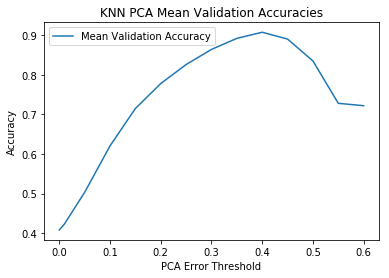

In [19]:
# plot KNN accuracies
def plot_accuracies(k, accuracies, methods, title, xlabel, ylabel):
    
    for i in range(len(accuracies)):
        plt.plot(k, accuracies[i], label=methods[i])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

k = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6] 
accuracies = [[0.4082285714285714,0.4228571428571429,0.5033142857142858,0.6205714285714286,0.7150285714285715,0.7780571428571429,0.8261142857142858,0.8643428571428572,0.8922285714285714,0.9077142857142857,0.8904571428571428,0.8352,0.7281142857142857,0.7220571428571428]]
plot_accuracies(k, accuracies, ["Mean Validation Accuracy"], "KNN PCA Mean Validation Accuracies", "PCA Error Threshold", "Accuracy")

In [ ]:
# find kNN PCA mean validation accuracies

1
Elapsed Time: 68.01508784294128
Fold 1 accuracy: 0.7288571428571429
Elapsed Time: 68.10698223114014
Fold 2 accuracy: 0.7394285714285714
Elapsed Time: 36.53410840034485
Fold 3 accuracy: 0.7348571428571429
Elapsed Time: 68.06460380554199
Fold 4 accuracy: 0.7117142857142857
Elapsed Time: 68.09760069847107
Fold 5 accuracy: 0.7308571428571429
Mean validation accuracy: 0.7291428571428572
2
Elapsed Time: 68.17025780677795
Fold 1 accuracy: 0.7805714285714286
Elapsed Time: 68.27965021133423
Fold 2 accuracy: 0.7868571428571428
Elapsed Time: 36.54194498062134
Fold 3 accuracy: 0.7837142857142857
Elapsed Time: 68.12303280830383
Fold 4 accuracy: 0.7608571428571429
Elapsed Time: 68.10920310020447
Fold 5 accuracy: 0.7782857142857142
Mean validation accuracy: 0.7780571428571429
3
Elapsed Time: 68.12933325767517
Fold 1 accuracy: 0.8008571428571428
Elapsed Time: 68.12192344665527
Fold 2 accuracy: 0.8002857142857143
Elapsed Time: 36.496620655059814
Fold 3 accuracy: 0.802
Elapsed Time: 68.14678931236267


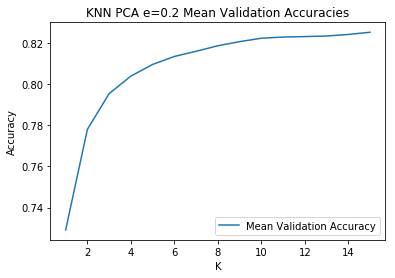

In [30]:
accuracies_p_0_2 = []
k = [i for i in range(1, 16)]
for i in range(1, 16):
    print(i)
    accuracies_p_0_2.append(train_knn_with_validation(p_training_imgs_0_2, training_labels, i, folds=5)[0])
plot_accuracies(k, [accuracies_p_0_2], ["Mean Validation Accuracy"], "KNN PCA e=0.2 Mean Validation Accuracies", "K", "Accuracy")

1
Elapsed Time: 25.98608112335205
Fold 1 accuracy: 0.7871428571428571
Elapsed Time: 25.816349983215332
Fold 2 accuracy: 0.7942857142857143
Elapsed Time: 25.72855806350708
Fold 3 accuracy: 0.7865714285714286
Elapsed Time: 25.827789545059204
Fold 4 accuracy: 0.77
Elapsed Time: 25.754974126815796
Fold 5 accuracy: 0.786
Mean validation accuracy: 0.7847999999999999
2
Elapsed Time: 25.792268753051758
Fold 1 accuracy: 0.8322857142857143
Elapsed Time: 25.819154739379883
Fold 2 accuracy: 0.8294285714285714
Elapsed Time: 25.84710431098938
Fold 3 accuracy: 0.8331428571428572
Elapsed Time: 25.780762672424316
Fold 4 accuracy: 0.8122857142857143
Elapsed Time: 25.745757341384888
Fold 5 accuracy: 0.8234285714285714
Mean validation accuracy: 0.8261142857142858
3
Elapsed Time: 25.87129282951355
Fold 1 accuracy: 0.8391428571428572
Elapsed Time: 25.83722162246704
Fold 2 accuracy: 0.8422857142857143
Elapsed Time: 25.751694679260254
Fold 3 accuracy: 0.85
Elapsed Time: 25.802143335342407
Fold 4 accuracy: 0.8

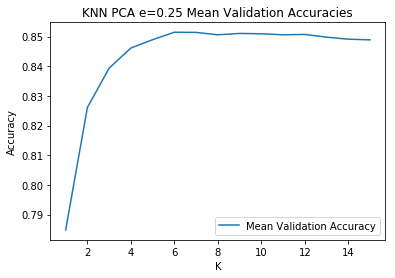

In [31]:
accuracies_p_0_25 = []
k = [i for i in range(1, 16)]
for i in range(1, 16):
    print(i)
    accuracies_p_0_25.append(train_knn_with_validation(p_training_imgs_0_25, training_labels, i, folds=5)[0])
plot_accuracies(k, [accuracies_p_0_25], ["Mean Validation Accuracy"], "KNN PCA e=0.25 Mean Validation Accuracies", "K", "Accuracy")

1
Elapsed Time: 17.844974279403687
Fold 1 accuracy: 0.8337142857142857
Elapsed Time: 29.526137828826904
Fold 2 accuracy: 0.836
Elapsed Time: 17.758407831192017
Fold 3 accuracy: 0.8382857142857143
Elapsed Time: 29.6828191280365
Fold 4 accuracy: 0.828
Elapsed Time: 17.765440702438354
Fold 5 accuracy: 0.8282857142857143
Mean validation accuracy: 0.832857142857143
2
Elapsed Time: 17.768818616867065
Fold 1 accuracy: 0.8654285714285714
Elapsed Time: 29.698198795318604
Fold 2 accuracy: 0.8711428571428571
Elapsed Time: 17.725080251693726
Fold 3 accuracy: 0.8705714285714286
Elapsed Time: 29.42976665496826
Fold 4 accuracy: 0.8554285714285714
Elapsed Time: 17.754724502563477
Fold 5 accuracy: 0.8591428571428571
Mean validation accuracy: 0.8643428571428572
3
Elapsed Time: 17.80007243156433
Fold 1 accuracy: 0.8728571428571429
Elapsed Time: 30.098318576812744
Fold 2 accuracy: 0.8765714285714286
Elapsed Time: 17.668286561965942
Fold 3 accuracy: 0.8791428571428571
Elapsed Time: 30.89050602912903
Fold 4

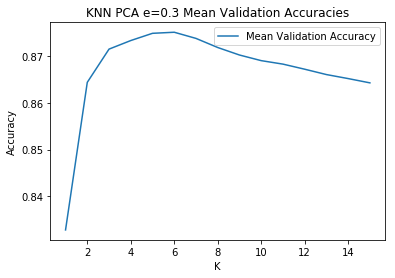

In [28]:
accuracies_p_0_3 = []
k = [i for i in range(1, 16)]
for i in range(1, 16):
    print(i)
    accuracies_p_0_3.append(train_knn_with_validation(p_training_imgs_0_3, training_labels, i, folds=5)[0])
plot_accuracies(k, [accuracies_p_0_3], ["Mean Validation Accuracy"], "KNN PCA e=0.3 Mean Validation Accuracies", "K", "Accuracy")

1
Elapsed Time: 11.787156105041504
Fold 1 accuracy: 0.874
Elapsed Time: 11.78557276725769
Fold 2 accuracy: 0.8742857142857143
Elapsed Time: 11.770760297775269
Fold 3 accuracy: 0.872
Elapsed Time: 11.72448468208313
Fold 4 accuracy: 0.8628571428571429
Elapsed Time: 11.771385192871094
Fold 5 accuracy: 0.866
Mean validation accuracy: 0.8698285714285714
2
Elapsed Time: 11.766964673995972
Fold 1 accuracy: 0.8965714285714286
Elapsed Time: 11.819904565811157
Fold 2 accuracy: 0.8971428571428571
Elapsed Time: 11.755054235458374
Fold 3 accuracy: 0.8965714285714286
Elapsed Time: 11.7816903591156
Fold 4 accuracy: 0.8831428571428571
Elapsed Time: 11.813822984695435
Fold 5 accuracy: 0.8877142857142857
Mean validation accuracy: 0.8922285714285714
3
Elapsed Time: 11.786949396133423
Fold 1 accuracy: 0.8962857142857142
Elapsed Time: 11.81215763092041
Fold 2 accuracy: 0.8951428571428571
Elapsed Time: 11.801284551620483
Fold 3 accuracy: 0.8988571428571429
Elapsed Time: 11.757150650024414
Fold 4 accuracy: 0

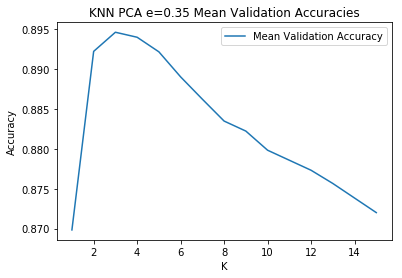

In [29]:
accuracies_p_0_35 = []
k = [i for i in range(1, 16)]
for i in range(1, 16):
    print(i)
    accuracies_p_0_35.append(train_knn_with_validation(p_training_imgs_0_35, training_labels, i, folds=5)[0])
plot_accuracies(k, [accuracies_p_0_35], ["Mean Validation Accuracy"], "KNN PCA e=0.35 Mean Validation Accuracies", "K", "Accuracy")

1
Elapsed Time: 6.843340873718262
Fold 1 accuracy: 0.9045714285714286
Elapsed Time: 6.789116621017456
Fold 2 accuracy: 0.8954285714285715
Elapsed Time: 6.7584228515625
Fold 3 accuracy: 0.8968571428571429
Elapsed Time: 6.806224584579468
Fold 4 accuracy: 0.8882857142857142
Elapsed Time: 6.797377824783325
Fold 5 accuracy: 0.8891428571428571
Mean validation accuracy: 0.8948571428571428
2
Elapsed Time: 6.804372787475586
Fold 1 accuracy: 0.9162857142857143
Elapsed Time: 6.786291122436523
Fold 2 accuracy: 0.9114285714285715
Elapsed Time: 6.807417154312134
Fold 3 accuracy: 0.9108571428571428
Elapsed Time: 6.755542993545532
Fold 4 accuracy: 0.8994285714285715
Elapsed Time: 6.807815790176392
Fold 5 accuracy: 0.9005714285714286
Mean validation accuracy: 0.9077142857142857
3
Elapsed Time: 6.813917398452759
Fold 1 accuracy: 0.9068571428571428
Elapsed Time: 6.7723774909973145
Fold 2 accuracy: 0.9042857142857142
Elapsed Time: 6.840315103530884
Fold 3 accuracy: 0.9057142857142857
Elapsed Time: 6.77796

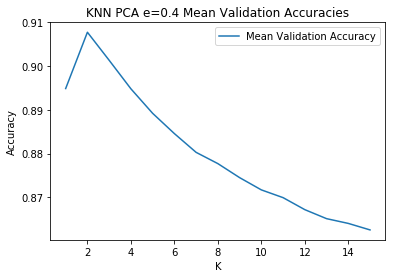

In [25]:
accuracies_p_0_4 = []
k = [i for i in range(1, 16)]
for i in range(1, 16):
    print(i)
    accuracies_p_0_4.append(train_knn_with_validation(p_training_imgs_0_4, training_labels, i, folds=5)[0])
plot_accuracies(k, [accuracies_p_0_4], ["Mean Validation Accuracy"], "KNN PCA e=0.4 Mean Validation Accuracies", "K", "Accuracy")

1
Elapsed Time: 4.788084506988525
Fold 1 accuracy: 0.8865714285714286
Elapsed Time: 4.7618937492370605
Fold 2 accuracy: 0.8851428571428571
Elapsed Time: 4.767270088195801
Fold 3 accuracy: 0.8891428571428571
Elapsed Time: 4.745532751083374
Fold 4 accuracy: 0.8754285714285714
Elapsed Time: 4.770318269729614
Fold 5 accuracy: 0.8788571428571429
Mean validation accuracy: 0.8830285714285715
2
Elapsed Time: 4.8074049949646
Fold 1 accuracy: 0.8951428571428571
Elapsed Time: 4.7810070514678955
Fold 2 accuracy: 0.8897142857142857
Elapsed Time: 4.74472975730896
Fold 3 accuracy: 0.8928571428571429
Elapsed Time: 4.751572847366333
Fold 4 accuracy: 0.8882857142857142
Elapsed Time: 4.756488561630249
Fold 5 accuracy: 0.8862857142857142
Mean validation accuracy: 0.8904571428571428
3
Elapsed Time: 4.80774450302124
Fold 1 accuracy: 0.8908571428571429
Elapsed Time: 4.762845993041992
Fold 2 accuracy: 0.8808571428571429
Elapsed Time: 4.736537218093872
Fold 3 accuracy: 0.8874285714285715
Elapsed Time: 4.757828

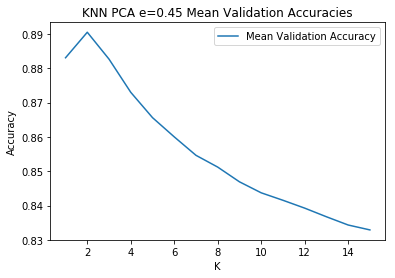

In [26]:
accuracies_p_0_45 = []
k = [i for i in range(1, 16)]
for i in range(1, 16):
    print(i)
    accuracies_p_0_45.append(train_knn_with_validation(p_training_imgs_0_45, training_labels, i, folds=5)[0])
plot_accuracies(k, [accuracies_p_0_45], ["Mean Validation Accuracy"], "KNN PCA e=0.45 Mean Validation Accuracies", "K", "Accuracy")

1
Elapsed Time: 4.237545967102051
Fold 1 accuracy: 0.8274285714285714
Elapsed Time: 4.250417470932007
Fold 2 accuracy: 0.8288571428571428
Elapsed Time: 4.2021777629852295
Fold 3 accuracy: 0.828
Elapsed Time: 4.196606874465942
Fold 4 accuracy: 0.8188571428571428
Elapsed Time: 4.209228277206421
Fold 5 accuracy: 0.8137142857142857
Mean validation accuracy: 0.8233714285714285
2
Elapsed Time: 4.232229948043823
Fold 1 accuracy: 0.8394285714285714
Elapsed Time: 4.241715431213379
Fold 2 accuracy: 0.834
Elapsed Time: 4.209637641906738
Fold 3 accuracy: 0.8385714285714285
Elapsed Time: 4.218854188919067
Fold 4 accuracy: 0.8342857142857143
Elapsed Time: 4.215384006500244
Fold 5 accuracy: 0.8297142857142857
Mean validation accuracy: 0.8352
3
Elapsed Time: 4.24015998840332
Fold 1 accuracy: 0.8322857142857143
Elapsed Time: 4.230210304260254
Fold 2 accuracy: 0.824
Elapsed Time: 4.212842226028442
Fold 3 accuracy: 0.8337142857142857
Elapsed Time: 4.215245962142944
Fold 4 accuracy: 0.8262857142857143
Ela

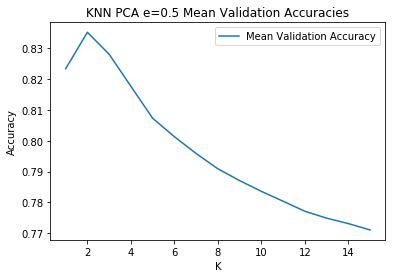

In [23]:
accuracies_p_0_5 = []
k = [i for i in range(1, 16)]
for i in range(1, 16):
    print(i)
    accuracies_p_0_5.append(train_knn_with_validation(p_training_imgs_0_5, training_labels, i, folds=5)[0])
plot_accuracies(k, [accuracies_p_0_5], ["Mean Validation Accuracy"], "KNN PCA e=0.5 Mean Validation Accuracies", "K", "Accuracy")

1
Elapsed Time: 4.01740837097168
Fold 1 accuracy: 0.65
Elapsed Time: 4.003269672393799
Fold 2 accuracy: 0.6605714285714286
Elapsed Time: 3.9895260334014893
Fold 3 accuracy: 0.652
Elapsed Time: 4.00587797164917
Fold 4 accuracy: 0.6437142857142857
Elapsed Time: 3.985542058944702
Fold 5 accuracy: 0.6411428571428571
Mean validation accuracy: 0.6494857142857142
2
Elapsed Time: 3.9980664253234863
Fold 1 accuracy: 0.7248571428571429
Elapsed Time: 4.014162063598633
Fold 2 accuracy: 0.722
Elapsed Time: 3.969728469848633
Fold 3 accuracy: 0.7331428571428571
Elapsed Time: 3.984668493270874
Fold 4 accuracy: 0.7357142857142858
Elapsed Time: 3.9776573181152344
Fold 5 accuracy: 0.7248571428571429
Mean validation accuracy: 0.7281142857142857
3
Elapsed Time: 4.01725959777832
Fold 1 accuracy: 0.7414285714285714
Elapsed Time: 4.031963109970093
Fold 2 accuracy: 0.7374285714285714
Elapsed Time: 3.9893293380737305
Fold 3 accuracy: 0.752
Elapsed Time: 3.9947593212127686
Fold 4 accuracy: 0.7542857142857143
Ela

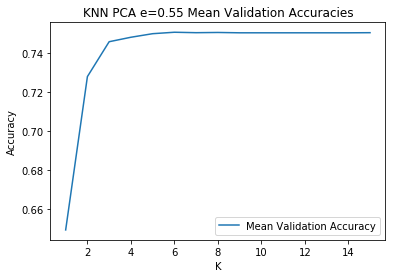

In [27]:
accuracies_p_0_55 = []
k = [i for i in range(1, 16)]
for i in range(1, 16):
    print(i)
    accuracies_p_0_55.append(train_knn_with_validation(p_training_imgs_0_55, training_labels, i, folds=5)[0])
plot_accuracies(k, [accuracies_p_0_55], ["Mean Validation Accuracy"], "KNN PCA e=0.55 Mean Validation Accuracies", "K", "Accuracy")

1
Elapsed Time: 3.940403461456299
Fold 1 accuracy: 0.6317142857142857
Elapsed Time: 3.930983066558838
Fold 2 accuracy: 0.6471428571428571
Elapsed Time: 3.928196430206299
Fold 3 accuracy: 0.6468571428571429
Elapsed Time: 3.913283109664917
Fold 4 accuracy: 0.6511428571428571
Elapsed Time: 3.916943073272705
Fold 5 accuracy: 0.6368571428571429
Mean validation accuracy: 0.6427428571428572
2
Elapsed Time: 3.9521384239196777
Fold 1 accuracy: 0.7191428571428572
Elapsed Time: 3.94775390625
Fold 2 accuracy: 0.716
Elapsed Time: 3.9385883808135986
Fold 3 accuracy: 0.7231428571428572
Elapsed Time: 3.9057960510253906
Fold 4 accuracy: 0.732
Elapsed Time: 3.909611463546753
Fold 5 accuracy: 0.72
Mean validation accuracy: 0.7220571428571428
3
Elapsed Time: 3.951711654663086
Fold 1 accuracy: 0.7437142857142857
Elapsed Time: 3.9521422386169434
Fold 2 accuracy: 0.7377142857142858
Elapsed Time: 3.927417755126953
Fold 3 accuracy: 0.7434285714285714
Elapsed Time: 3.9314043521881104
Fold 4 accuracy: 0.75542857

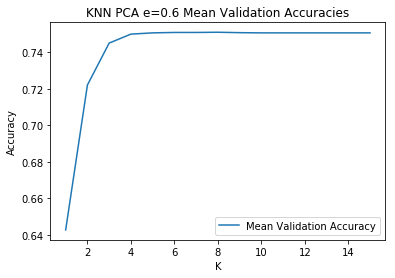

In [24]:
accuracies_p_0_6 = []
k = [i for i in range(1, 16)]
for i in range(1, 16):
    print(i)
    accuracies_p_0_6.append(train_knn_with_validation(p_training_imgs_0_6, training_labels, i, folds=5)[0])
plot_accuracies(k, [accuracies_p_0_6], ["Mean Validation Accuracy"], "KNN PCA e=0.6 Mean Validation Accuracies", "K", "Accuracy")

1
Elapsed Time: 3.9310319423675537
Fold 1 accuracy: 0.8997142857142857
Elapsed Time: 3.91951584815979
Fold 2 accuracy: 0.9037142857142857
Elapsed Time: 3.9048826694488525
Fold 3 accuracy: 0.9042857142857142
Elapsed Time: 3.916654109954834
Fold 4 accuracy: 0.91
Elapsed Time: 3.9157469272613525
Fold 5 accuracy: 0.9085714285714286
Mean validation accuracy: 0.905257142857143
2
Elapsed Time: 3.937354326248169
Fold 1 accuracy: 0.9022857142857142
Elapsed Time: 3.9281623363494873
Fold 2 accuracy: 0.9034285714285715
Elapsed Time: 3.9057068824768066
Fold 3 accuracy: 0.9065714285714286
Elapsed Time: 3.954970359802246
Fold 4 accuracy: 0.908
Elapsed Time: 3.936702251434326
Fold 5 accuracy: 0.9082857142857143
Mean validation accuracy: 0.9057142857142857
3
Elapsed Time: 3.9361064434051514
Fold 1 accuracy: 0.8931428571428571
Elapsed Time: 3.9283533096313477
Fold 2 accuracy: 0.8911428571428571
Elapsed Time: 3.9148638248443604
Fold 3 accuracy: 0.8997142857142857
Elapsed Time: 3.916757106781006
Fold 4 ac

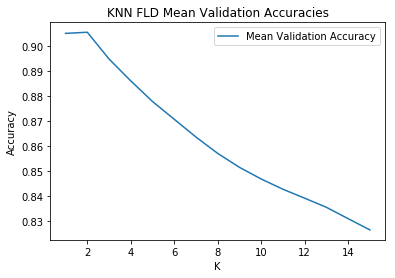

In [34]:
# get FLD mean validation accuracies
accuracies_f = []
k = [i for i in range(1, 16)]
for i in range(1, 16):
    print(i)
    accuracies_f.append(train_knn_with_validation(f_training_images, training_labels, i, folds=5)[0])
plot_accuracies(k, [accuracies_f], ["Mean Validation Accuracy"], "KNN FLD Mean Validation Accuracies", "K", "Accuracy")

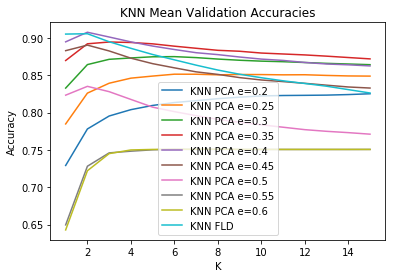

In [36]:
accuracies = [accuracies_p_0_2, accuracies_p_0_25, accuracies_p_0_3, accuracies_p_0_35, accuracies_p_0_4, accuracies_p_0_45, accuracies_p_0_5, accuracies_p_0_55, accuracies_p_0_6, accuracies_f]
names = ['KNN PCA e=0.2', 'KNN PCA e=0.25', 'KNN PCA e=0.3', 'KNN PCA e=0.35', 'KNN PCA e=0.4', 'KNN PCA e=0.45', 'KNN PCA e=0.5', 'KNN PCA e=0.55', 'KNN PCA e=0.6', 'KNN FLD']

plot_accuracies(k, accuracies, names, "KNN Mean Validation Accuracies", "K", "Accuracy")

Elapsed Time: 3.94726300239563
Fold 1 accuracy: 0.8997142857142857
Elapsed Time: 3.9240756034851074
Fold 2 accuracy: 0.9037142857142857
Elapsed Time: 3.940302610397339
Fold 3 accuracy: 0.9042857142857142
Elapsed Time: 3.9551305770874023
Fold 4 accuracy: 0.91
Elapsed Time: 3.9362542629241943
Fold 5 accuracy: 0.9085714285714286
Mean validation accuracy: 0.905257142857143
Elapsed Time: 3.938312292098999
Fold 1 accuracy: 0.9022857142857142
Elapsed Time: 3.945418357849121
Fold 2 accuracy: 0.9034285714285715
Elapsed Time: 3.9205820560455322
Fold 3 accuracy: 0.9065714285714286
Elapsed Time: 3.937609910964966
Fold 4 accuracy: 0.908
Elapsed Time: 3.952509641647339
Fold 5 accuracy: 0.9082857142857143
Mean validation accuracy: 0.9057142857142857
Elapsed Time: 3.939148426055908
Fold 1 accuracy: 0.8931428571428571
Elapsed Time: 3.936225175857544
Fold 2 accuracy: 0.8911428571428571
Elapsed Time: 3.9229798316955566
Fold 3 accuracy: 0.8997142857142857
Elapsed Time: 3.9233298301696777
Fold 4 accuracy: 

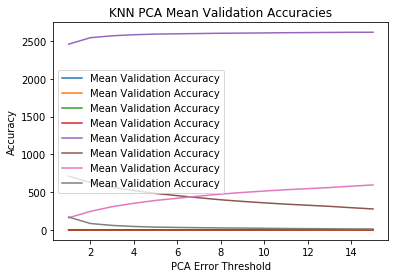

In [22]:
# get kNN mean validation accuracies
accuracies = []
k = [i for i in range(1, 16)]
for i in range(1, 16):
    accuracies.append(train_knn_with_validation(f_training_images, training_labels, i, folds=5))

[array([9.05257143e-01, 9.35220295e-01, 9.38347979e-01, 8.15291807e-01,
       2.45700000e+03, 7.11400000e+02, 1.61400000e+02, 1.70200000e+02]), array([9.05714286e-01, 9.67659047e-01, 9.12093681e-01, 7.19414569e-01,
       2.54220000e+03, 6.27800000e+02, 2.45000000e+02, 8.50000000e+01]), array([8.94971429e-01, 9.77246170e-01, 8.92946834e-01, 6.47456142e-01,
       2.56740000e+03, 5.65000000e+02, 3.07800000e+02, 5.98000000e+01]), array([8.86171429e-01, 9.82577657e-01, 8.79813884e-01, 5.96079889e-01,
       2.58140000e+03, 5.20200000e+02, 3.52600000e+02, 4.58000000e+01]), array([8.77885714e-01, 9.85840753e-01, 8.69057595e-01, 5.52991553e-01,
       2.59000000e+03, 4.82600000e+02, 3.90200000e+02, 3.72000000e+01]), array([8.70742857e-01, 9.87360228e-01, 8.60867275e-01, 5.19734120e-01,
       2.59400000e+03, 4.53600000e+02, 4.19200000e+02, 3.32000000e+01]), array([8.63600000e-01, 9.88578849e-01, 8.53047091e-01, 4.87474366e-01,
       2.59720000e+03, 4.25400000e+02, 4.47400000e+02, 3.0000000

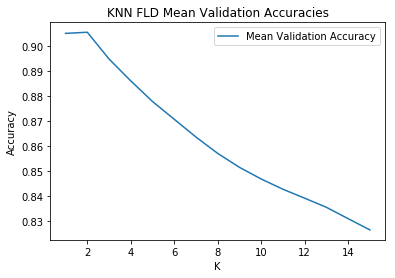

In [28]:
# plot kNN FLD accuracies
plot_accuracies(k, [[a[0] for a in accuracies]], ["Mean Validation Accuracy"], "KNN FLD Mean Validation Accuracies", "K", "Accuracy")

In [29]:
# generate knn roc curve via sklearn
# adapted from example at: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

def sklearn_roc_knn(X, y):
    
    # plot roc curve using k-fold cross validation
    cv = StratifiedKFold(n_splits=10)
    classifier = KNeighborsClassifier(n_neighbors=2)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    # fit each classifier and derive FPRs, TPRs, and AUCs
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    # calculate means
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic KNN')
    plt.legend(loc="lower right")
    plt.show()

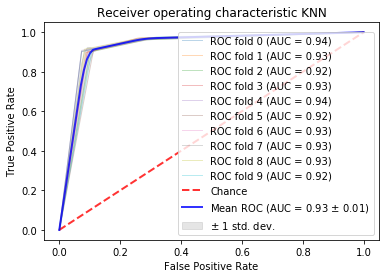

In [30]:
# plot sklearn ROC curve FLD data 
sklearn_roc_knn(f_training_images, training_labels)

In [ ]:
# plot sklearn ROC curve PCA dataset

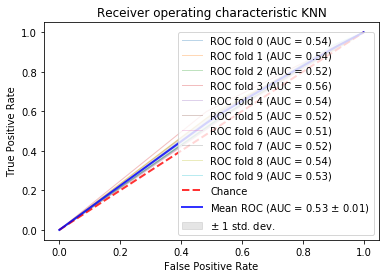

In [33]:
sklearn_roc_knn(p_training_imgs_0_6, training_labels)

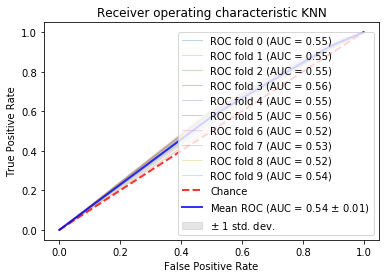

In [34]:
sklearn_roc_knn(p_training_imgs_0_55, training_labels)

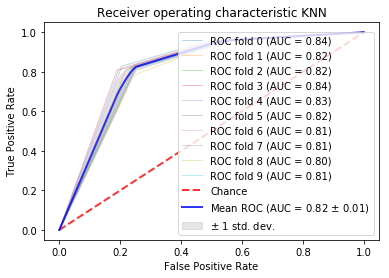

In [35]:
sklearn_roc_knn(p_training_imgs_0_5, training_labels)

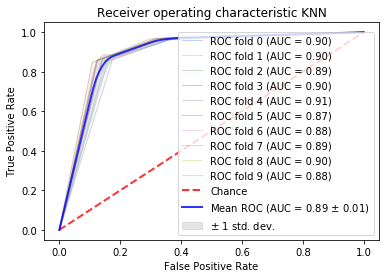

In [36]:
sklearn_roc_knn(p_training_imgs_0_45, training_labels)

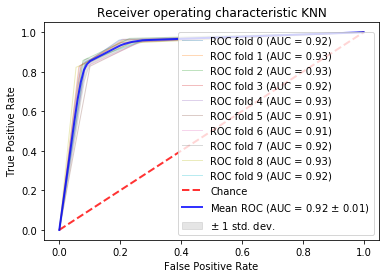

In [37]:
sklearn_roc_knn(p_training_imgs_0_4, training_labels)

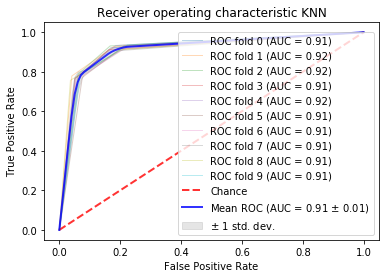

In [38]:
sklearn_roc_knn(p_training_imgs_0_35, training_labels)

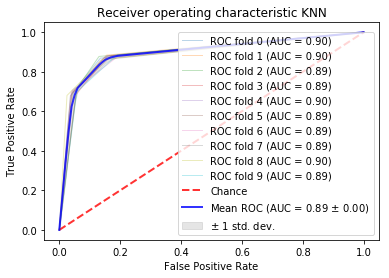

In [39]:
sklearn_roc_knn(p_training_imgs_0_3, training_labels)

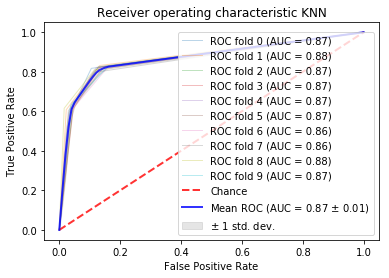

In [40]:
sklearn_roc_knn(p_training_imgs_0_25, training_labels)

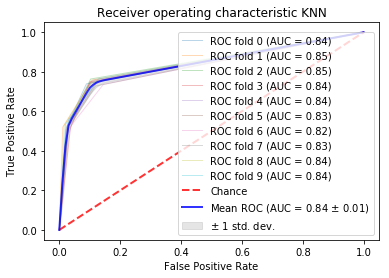

In [41]:
sklearn_roc_knn(p_training_imgs_0_2, training_labels)

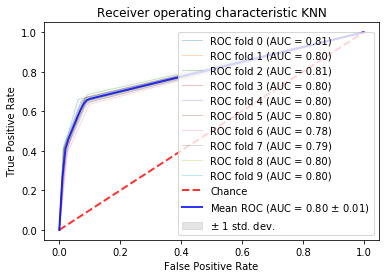

In [42]:
sklearn_roc_knn(p_training_imgs_0_15, training_labels)

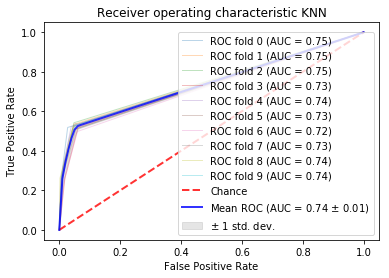

In [43]:
sklearn_roc_knn(p_training_imgs_0_1, training_labels)

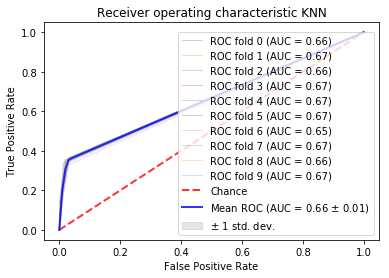

In [44]:
sklearn_roc_knn(p_training_imgs_0_05, training_labels)

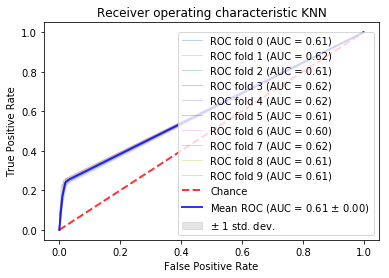

In [45]:
sklearn_roc_knn(p_training_imgs_0_01, training_labels)

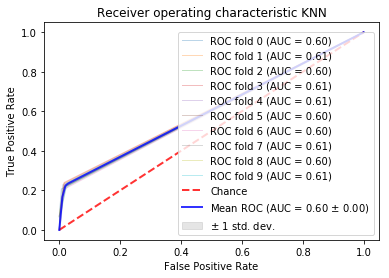

In [46]:
#plot sklearn ROC curve normalized data
sklearn_roc_knn(n_training_imgs, training_labels)

(17500, 25)

(17500, 2)


Text(0.5,1,'Aerial Cactus Training Data Set Image Vectors with Class Labels')

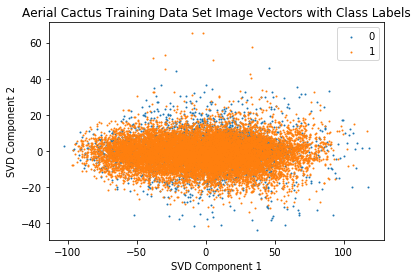

In [35]:
# plot samples in scatterplot

from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
X = p_training_imgs_0_4
svd = TruncatedSVD(n_components=2, random_state=42)
svd.fit(X)
X = svd.transform(X)
for i in range(0,2):
    x_c = [X[j,0] for j in range(0, len(X)) if training_labels[j] == i] 
    y_c = [X[j,1] for j in range(0, len(X)) if training_labels[j] == i] 
    plt.scatter(x_c, y_c, s = 1, label=i)
plt.legend()
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.title('Aerial Cactus Training Data Set Image Vectors with Class Labels')
